# 0. Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

In [1]:
# Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from glob import glob

import warnings

warnings.filterwarnings("ignore")


# 1. Data Reading/Data Understanding

Defining the path for train and test images

This assignment utilizes a dataset consisting of approximately 2,357 images, categorized into 9 different skin cancer types. The dataset is organized into two main directories: **train** and **test**, each containing 9 subdirectories. Each subdirectory corresponds to one of the 9 skin cancer types, containing the respective images for each type.

In [2]:
# Importing Skin Cancer Data
# Defining the path for train and test images from google drive

from google.colab import drive

drive.mount("/content/drive")

data_dir_train = pathlib.Path(
    "/content/drive/MyDrive/MachineLearning_ArtificialIntelligence/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
)
data_dir_test = pathlib.Path(
    "/content/drive/MyDrive/MachineLearning_ArtificialIntelligence/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"
)


Mounted at /content/drive


In [3]:
# Checking number of images in train folder

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [4]:
# Checking number of images in test folder

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [5]:
def class_distribution_count(directory):

    # count number of image in each classes
    count = []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(
                len(
                    [
                        name
                        for name in os.listdir(path)
                        if os.path.isfile(os.path.join(path, name))
                    ]
                )
            )

    # name of the classes
    sub_directory = [
        name
        for name in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, name))
    ]

    # return dataframe with image count and class.
    return pd.DataFrame(
        list(zip(sub_directory, count)), columns=["Class", "No. of Image"]
    )


df = class_distribution_count(data_dir_train)
df


,Class,No. of Image
0,nevus,357
1,melanoma,438
2,squamous cell carcinoma,181
3,vascular lesion,139
4,actinic keratosis,114
5,seborrheic keratosis,77
6,pigmented benign keratosis,462
7,dermatofibroma,95
8,basal cell carcinoma,376


In [7]:
df = class_distribution_count(data_dir_test)
df

,Class,No. of Image
0,vascular lesion,3
1,basal cell carcinoma,16
2,seborrheic keratosis,3
3,pigmented benign keratosis,16
4,squamous cell carcinoma,16
5,actinic keratosis,16
6,nevus,16
7,melanoma,16
8,dermatofibroma,16


<Axes: xlabel='No. of Image', ylabel='Class'>

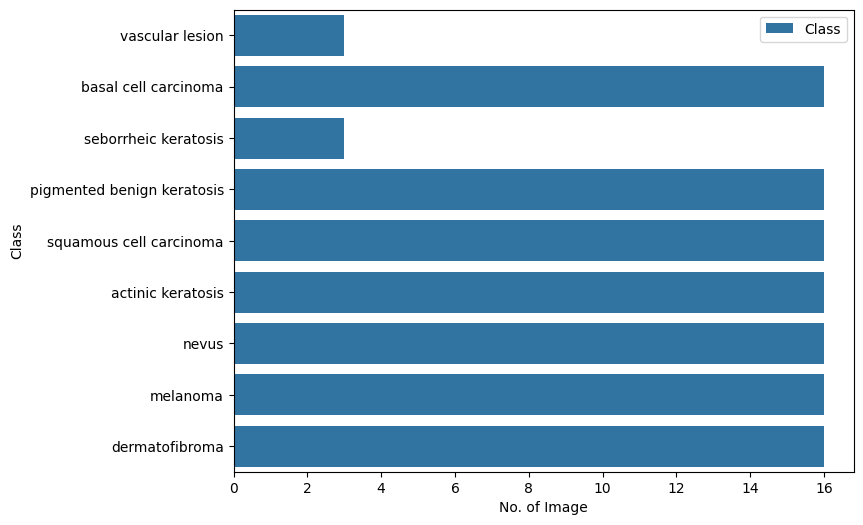

In [8]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [9]:
# Define basic parameters for the loader

batch_size = 32
img_height = 180
img_width = 180

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Use 80% of the images for training, and 20% for validation.

In [10]:
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [13]:
# Extracting all the classes of skin cancer and store them in a list.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# 3. Dataset visualization

Code to visualize one image of all the types of skin cancer

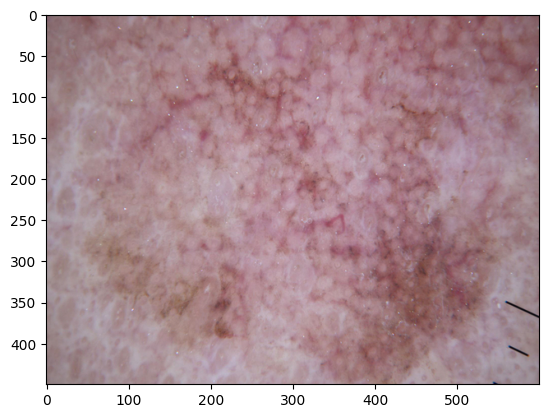

In [14]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

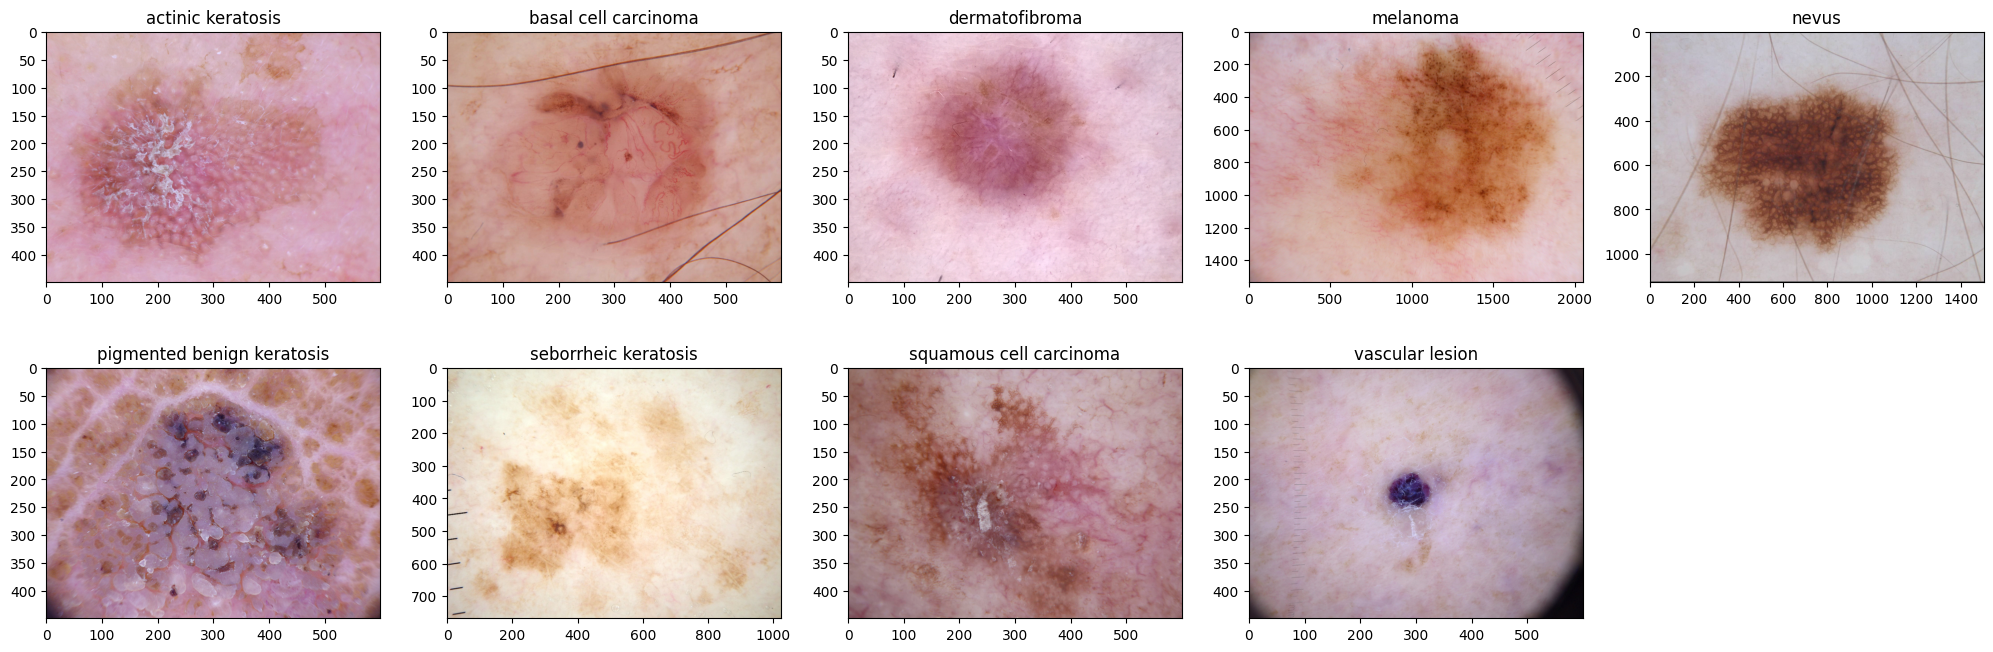

In [15]:
# Loop though the class names to get one image per class

plt.figure(figsize=(25,8))
for classnum in range(len(class_names)):
  plt.subplot(2,5,classnum+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[classnum]+'/*.jpg'))[1]))
  plt.title(class_names[classnum])
  plt.imshow(image)

In [16]:
# Set the AUTOTUNE parameter for performance optimization
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache and optimize the training dataset
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch for the test dataset (no shuffling for test data, as the order doesn't matter)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch for the validation dataset
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [18]:
# Method to create plots of the loss and accuracy on the training and validation sets:


def plot_cnn_metrics(history, epochs):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()


# 4. Model Building & training :

1.   I will choose an appropriate optimizer and loss function for model training.
2.   The model will be trained for approximately 20 epochs.
3.  After training, I will plot graphs to evaluate the model's performance and check for any signs of overfitting or underfitting.



In [21]:
# CNN Model
model=models.Sequential()

# scaling the pixel values from 0-255 to 0-1
# normalizing the pixel values here
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation and 2x2 pooling
model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution layer with 128 features, 3x3 filter and relu activation and 2x2 pooling
model.add(Conv2D(128,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution layer with 256 features, 3x3 filter and relu activation and 2x2 pooling
model.add(Conv2D(256,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      31,719,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,092,809 (122.42 MB)

 Trainable params: 32,092,809 (122.42 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compiling the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      31,719,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,092,809 (122.42 MB)

 Trainable params: 32,092,809 (122.42 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.2152 - loss: 3.0976 - val_accuracy: 0.3512 - val_loss: 1.7318
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.3899 - loss: 1.6869 - val_accuracy: 0.4787 - val_loss: 1.5201
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4978 - loss: 1.4830 - val_accuracy: 0.4474 - val_loss: 1.5886
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4898 - loss: 1.3946 - val_accuracy: 0.5369 - val_loss: 1.4239
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5518 - loss: 1.2594 - val_accuracy: 0.5638 - val_loss: 1.3370
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5998 - loss: 1.0976 - val_accuracy: 0.5347 - val_loss: 1.3541
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6160 - loss: 1.0791 - val_accuracy: 0.4877 - val_loss: 1.6332
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6254 - loss: 1.0533 - val_accuracy: 0.5347 - v

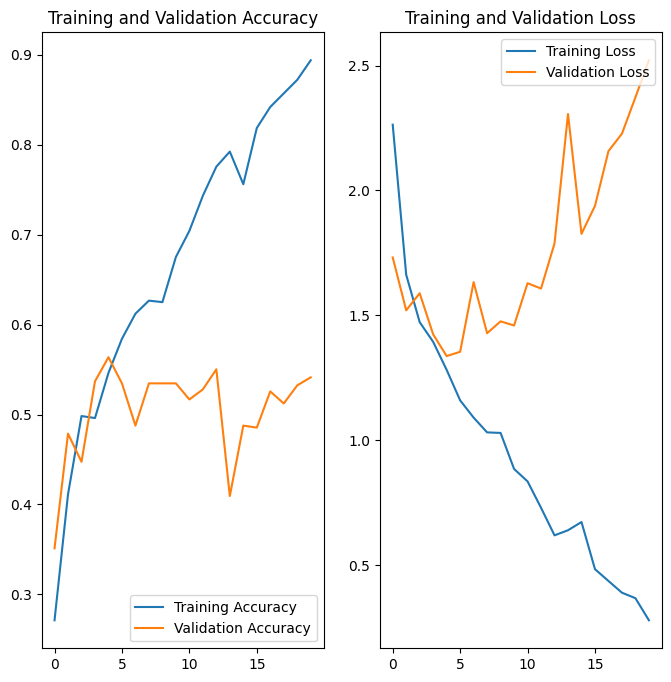

In [25]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings:**

1. Training Accuracy vs. Validation Accuracy: As the training accuracy increases linearly over time, the validation accuracy stalls around 50% throughout the training process.

2. Training Loss vs. Validation Loss: While the training loss decreases with each epoch, we observe that the validation loss increases over time.

3. Accuracy Comparison: The plots indicate a significant gap between training and validation accuracy, with the model achieving approximately 50% accuracy on the validation set.

4. Overfitting Observation: The noticeable difference in accuracy between training and validation sets suggests that the model is overfitting to the training data.



# 5. Choosing an right data augmentation strategy to resolve overfitting

Overfitting typically occurs when a model is trained on a limited amount of data, causing it to memorize the training examples rather than learning the underlying patterns. As a result, the model performs well on the training data but struggles to generalize to unseen data, leading to poor performance on validation or test sets.

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

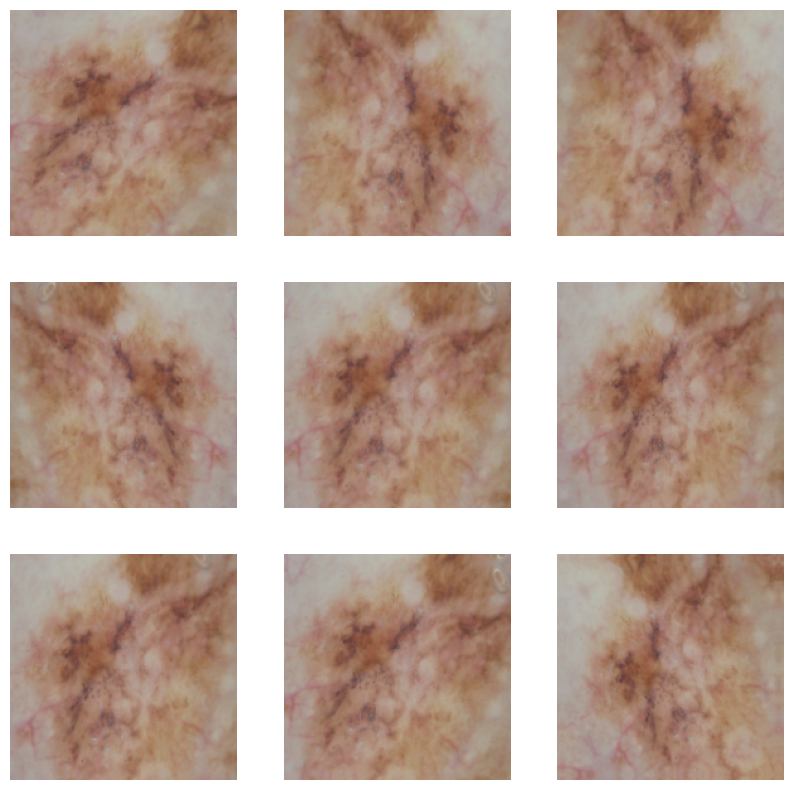

In [27]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# 6. Model Building & training on the augmented data :


In [28]:
# CNN Model
model=models.Sequential()

# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation and 2x2 pooling
model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution layer with 128 features, 3x3 filter and relu activation and 2x2 pooling
model.add(Conv2D(128,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution layer with 256 features, 3x3 filter and relu activation and 2x2 pooling
model.add(Conv2D(256,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [30]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      31,719,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,092,809 (122.42 MB)

 Trainable params: 32,092,809 (122.42 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.1816 - loss: 4.0274 - val_accuracy: 0.2841 - val_loss: 1.9003
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3117 - loss: 1.8906 - val_accuracy: 0.3468 - val_loss: 1.7444
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.4114 - loss: 1.6673 - val_accuracy: 0.4877 - val_loss: 1.4838
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.4890 - loss: 1.4304 - val_accuracy: 0.4362 - val_loss: 1.6759
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.4823 - loss: 1.4543 - val_accuracy: 0.4877 - val_loss: 1.4752
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5024 - loss: 1.4022 - val_accuracy: 0.4966 - val_loss: 1.3964
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.4911 - loss: 1.3790 - val_accuracy: 0.5391 - val_loss: 1.3294
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5328 - loss: 1.3055 - val_accuracy: 0.5347 -

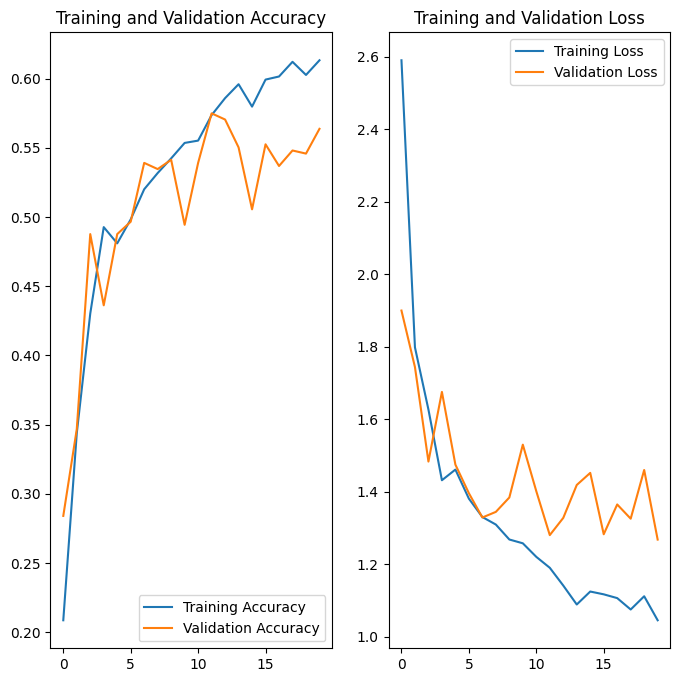

In [32]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings:**

# Analysis of Model Training and Validation Performance

1. Training Accuracy vs. Validation Accuracy: As the training accuracy increases linearly over time, the validation accuracy rises and then stalls at 55% during the training process.

2. Training Loss vs. Validation Loss: The training loss decreases with each epoch, and the validation loss also decreases but then reaches a plateau.

3. Accuracy Comparison: The gap between training accuracy and validation accuracy has narrowed compared to the previous model, with the validation set now achieving around 55% accuracy.

4. Overfitting Observation: Although the gap is smaller, the difference between training and validation accuracy is still slightly noticeable, indicating some degree of overfitting.



# 7. Model Building & training on the augmented data with dropout :


In [34]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding a 25% dropout after the convolution layer
model.add(Dropout(0.25))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding a 25% dropout after the convolution layer
model.add(Dropout(0.25))

# Convolution layer with 256 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(256,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding a 25% dropout after the convolution layer
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [35]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      31,719,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,092,809 (122.42 MB)

 Trainable params: 32,092,809 (122.42 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.1894 - loss: 4.9122 - val_accuracy: 0.2058 - val_loss: 2.0948
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.1853 - loss: 2.0486 - val_accuracy: 0.2058 - val_loss: 2.0497
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.2610 - loss: 1.9706 - val_accuracy: 0.3065 - val_loss: 1.8618
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.4071 - loss: 1.6790 - val_accuracy: 0.4452 - val_loss: 1.6336
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.4502 - loss: 1.5559 - val_accuracy: 0.3647 - val_loss: 1.7486
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.4650 - loss: 1.5270 - val_accuracy: 0.5168 - val_loss: 1.4630
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.4965 - loss: 1.4552 - val_accuracy: 0.4183 - val_loss: 1.6366
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.5105 - loss: 1.4092 - val_accuracy: 0

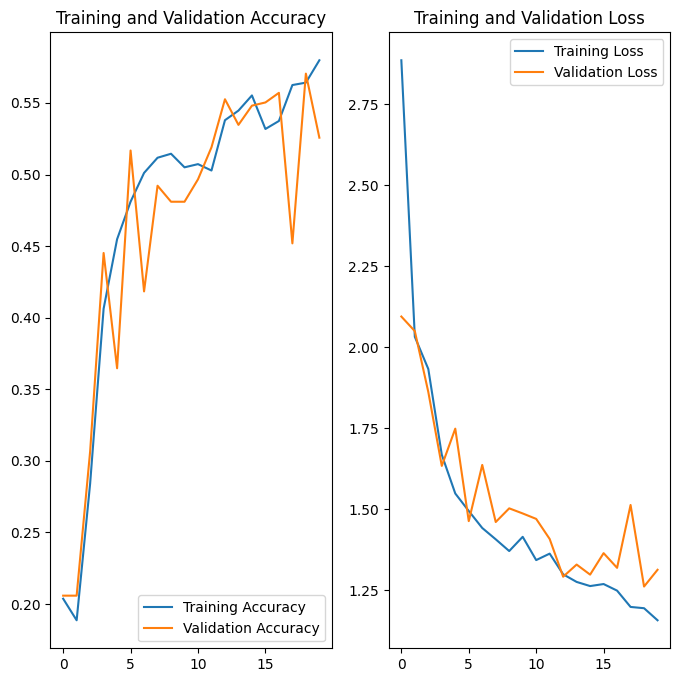

In [37]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings:**

1. As the training accuracy increases linearly over time, the validation accuracy increases and then stalls at 55% during the training process.
2. **As the training loss decreases with each epoch, the validation loss also decreases.**
3. The plots show that the gap between training accuracy and validation accuracy has decreased from the previous model, and it has achieved around **55%** accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is **negligible**.



### **We can clearly see that the overfitting of the model has reduced significantly when compared the earlier models**

# 8. Class distribution:

1. Examining the current class distribution in the training dataset
2. Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.
3. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
for i in range(len(class_names)):
    print(
        class_names[i], " - ", len(list(data_dir_train.glob(class_names[i] + "/*.jpg")))
    )


actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


**Findings:**

 - **seborrheic keratosis** with 77 samp
 - **pigmented benign keratosis** with 462 samples


# 9. Handling class imbalances:

Rectifing class imbalances present in the training dataset with Augmentor library.

In [40]:
!pip install Augmentor

In [41]:
path_to_training_dataset="/content/drive/MyDrive/MachineLearning_ArtificialIntelligence/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory="/kaggle/working/melanoma/"+i+"/")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/melanoma/actinic keratosis/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79EFBA2ADD50>: 100%|██████████| 500/500 [00:20<00:00, 24.75 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/melanoma/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EFBA23F710>: 100%|██████████| 500/500 [00:15<00:00, 33.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/melanoma/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79F03980ED50>: 100%|██████████| 500/500 [00:15<00:00, 32.05 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79EFBA6AF990>: 100%|██████████| 500/500 [01:14<00:00,  6.73 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/melanoma/nevus/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x79EFBA36F310>: 100%|██████████| 500/500 [01:11<00:00,  7.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/melanoma/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EFBA5CEFD0>: 100%|██████████| 500/500 [00:16<00:00, 30.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/melanoma/seborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79EFBA55F310>: 100%|██████████| 500/500 [00:34<00:00, 14.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/melanoma/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EFBA6ABF90>: 100%|██████████| 500/500 [00:15<00:00, 32.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/melanoma/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EFBA6C0D10>: 100%|██████████| 500/500 [00:15<00:00, 32.93 Samples/s]


The augmented images have been stored in the output sub-directory within each of the sub-directories corresponding to the skin cancer types. Let's check the total count of augmented images.

In [42]:
data_dir_train = pathlib.Path("/kaggle/working/melanoma/")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:

path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [44]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [45]:
df['Label'].value_counts()

,count
Label,
actinic keratosis,500
seborrheic keratosis,500
nevus,500
squamous cell carcinoma,500
pigmented benign keratosis,500
dermatofibroma,500
melanoma,500
vascular lesion,500
basal cell carcinoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [46]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [47]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


# 10. Model Building & training with existing model and by the rectified class imbalance data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [53]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution layer with 256 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding a 25% dropout after the convolution layers
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [54]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 87, 87, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 41, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 20, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 102400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │      26,214,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,587,785 (101.42 MB)

 Trainable params: 26,587,785 (101.42 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.1784 - loss: 2.3140 - val_accuracy: 0.3478 - val_loss: 1.7250
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.3739 - loss: 1.6255 - val_accuracy: 0.3700 - val_loss: 1.5332
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.4128 - loss: 1.4920 - val_accuracy: 0.4567 - val_loss: 1.3757
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.4490 - loss: 1.4077 - val_accuracy: 0.4544 - val_loss: 1.3544
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.4400 - loss: 1.4195 - val_accuracy: 0.4567 - val_loss: 1.3794
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.4766 - loss: 1.2958 - val_accuracy: 0.4900 - val_loss: 1.3169
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.5135 - loss: 1.2796 - val_accuracy: 0.5133 - val_loss: 1.2006
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.5297 - loss: 1

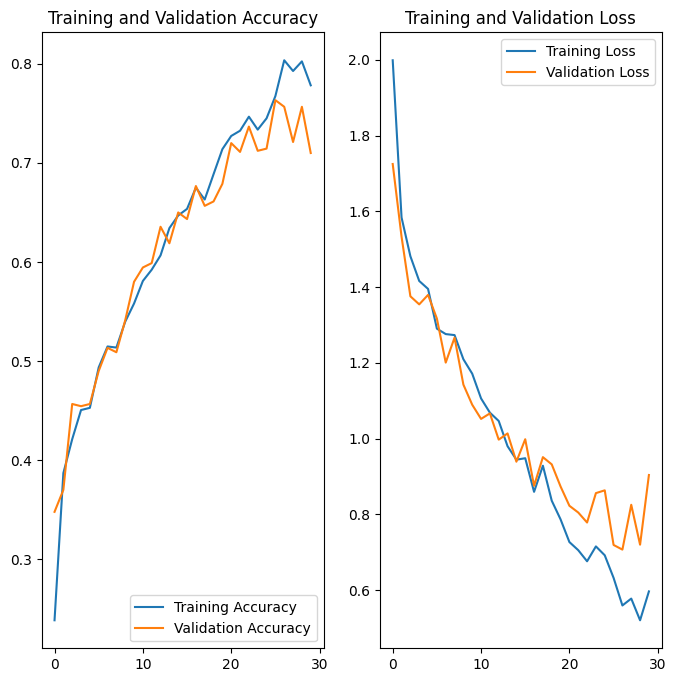

In [56]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

**Findings:**

1. As the training accuracy and validation accuracy increases linearly over time
2. As the training loss decreases with each epoch, the validation loss also decreases.
3. The plots show that the gap between training accuracy and validation accuracy has decreased compared to the previous model, and it has achieved around **79%** accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is **very small**.



1. Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 75%.


# 11. Model Prediction

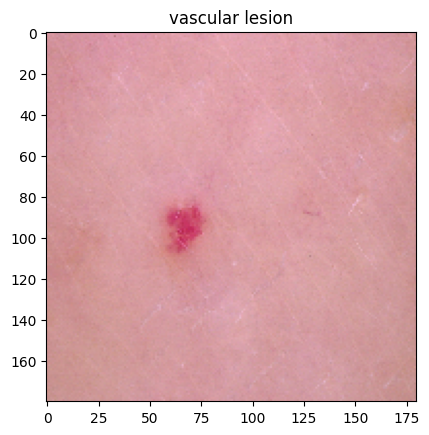

In [59]:
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[-1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.title(class_names[-1])
plt.grid(False)



In [60]:

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[-1] +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Actual Class vascular lesion
Predictive Class vascular lesion
